In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import seaborn as sns
import os, shutil, glob, gc 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, layers, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

In [2]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
!python -V

TensorFlow version: 2.11.0
Keras version: 2.11.0
Python 3.7.12


In [3]:
train_path = '/kaggle/input/datasetv2/train'

In [4]:
def extract_image_info(filepath):
    img = cv2.imread(filepath)
    h, w, c = img.shape
    img_class = os.path.basename(os.path.dirname(filepath)).split('.')[-1]
    return [w, h, img_class]

In [5]:
path_list_train = [path for path in glob.glob(train_path +'/**/*.jpg', recursive = True)]
print(f"Total train images: {len(path_list_train)}")

df = pd.DataFrame(path_list_train,columns=['filepath'])

df[['W', 'H', 'DogID']] = pd.DataFrame(df['filepath'].apply(extract_image_info).to_list())

Total train images: 26737


In [6]:
df

,filepath,W,H,DogID
0,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,276,183,0303
1,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,211,193,0303
2,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,193,189,0303
3,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,215,189,0303
4,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,260,182,0303
...,...,...,...,...
26732,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,31,43,0101
26733,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,21,43,0101
26734,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,43,44,0101
26735,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,52,40,0101


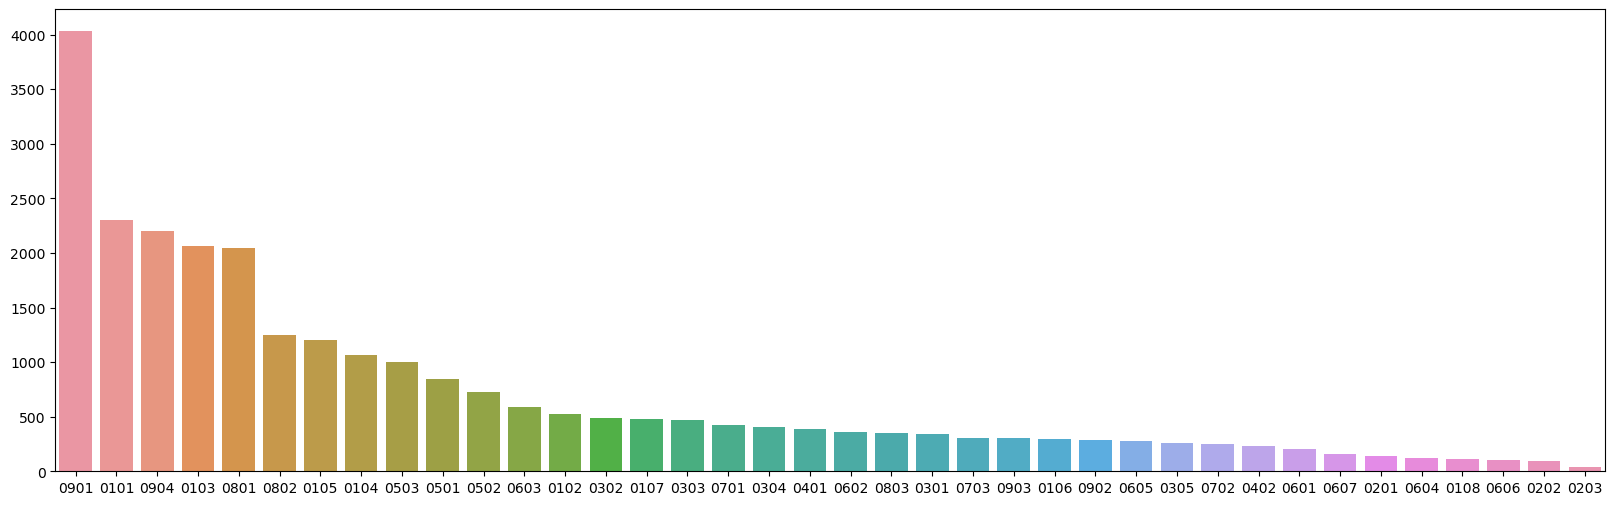

In [7]:
dog_counts = df['DogID'].value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(x=dog_counts.index, y=dog_counts.values)
plt.show()

In [8]:
len(df['DogID'].unique())

38

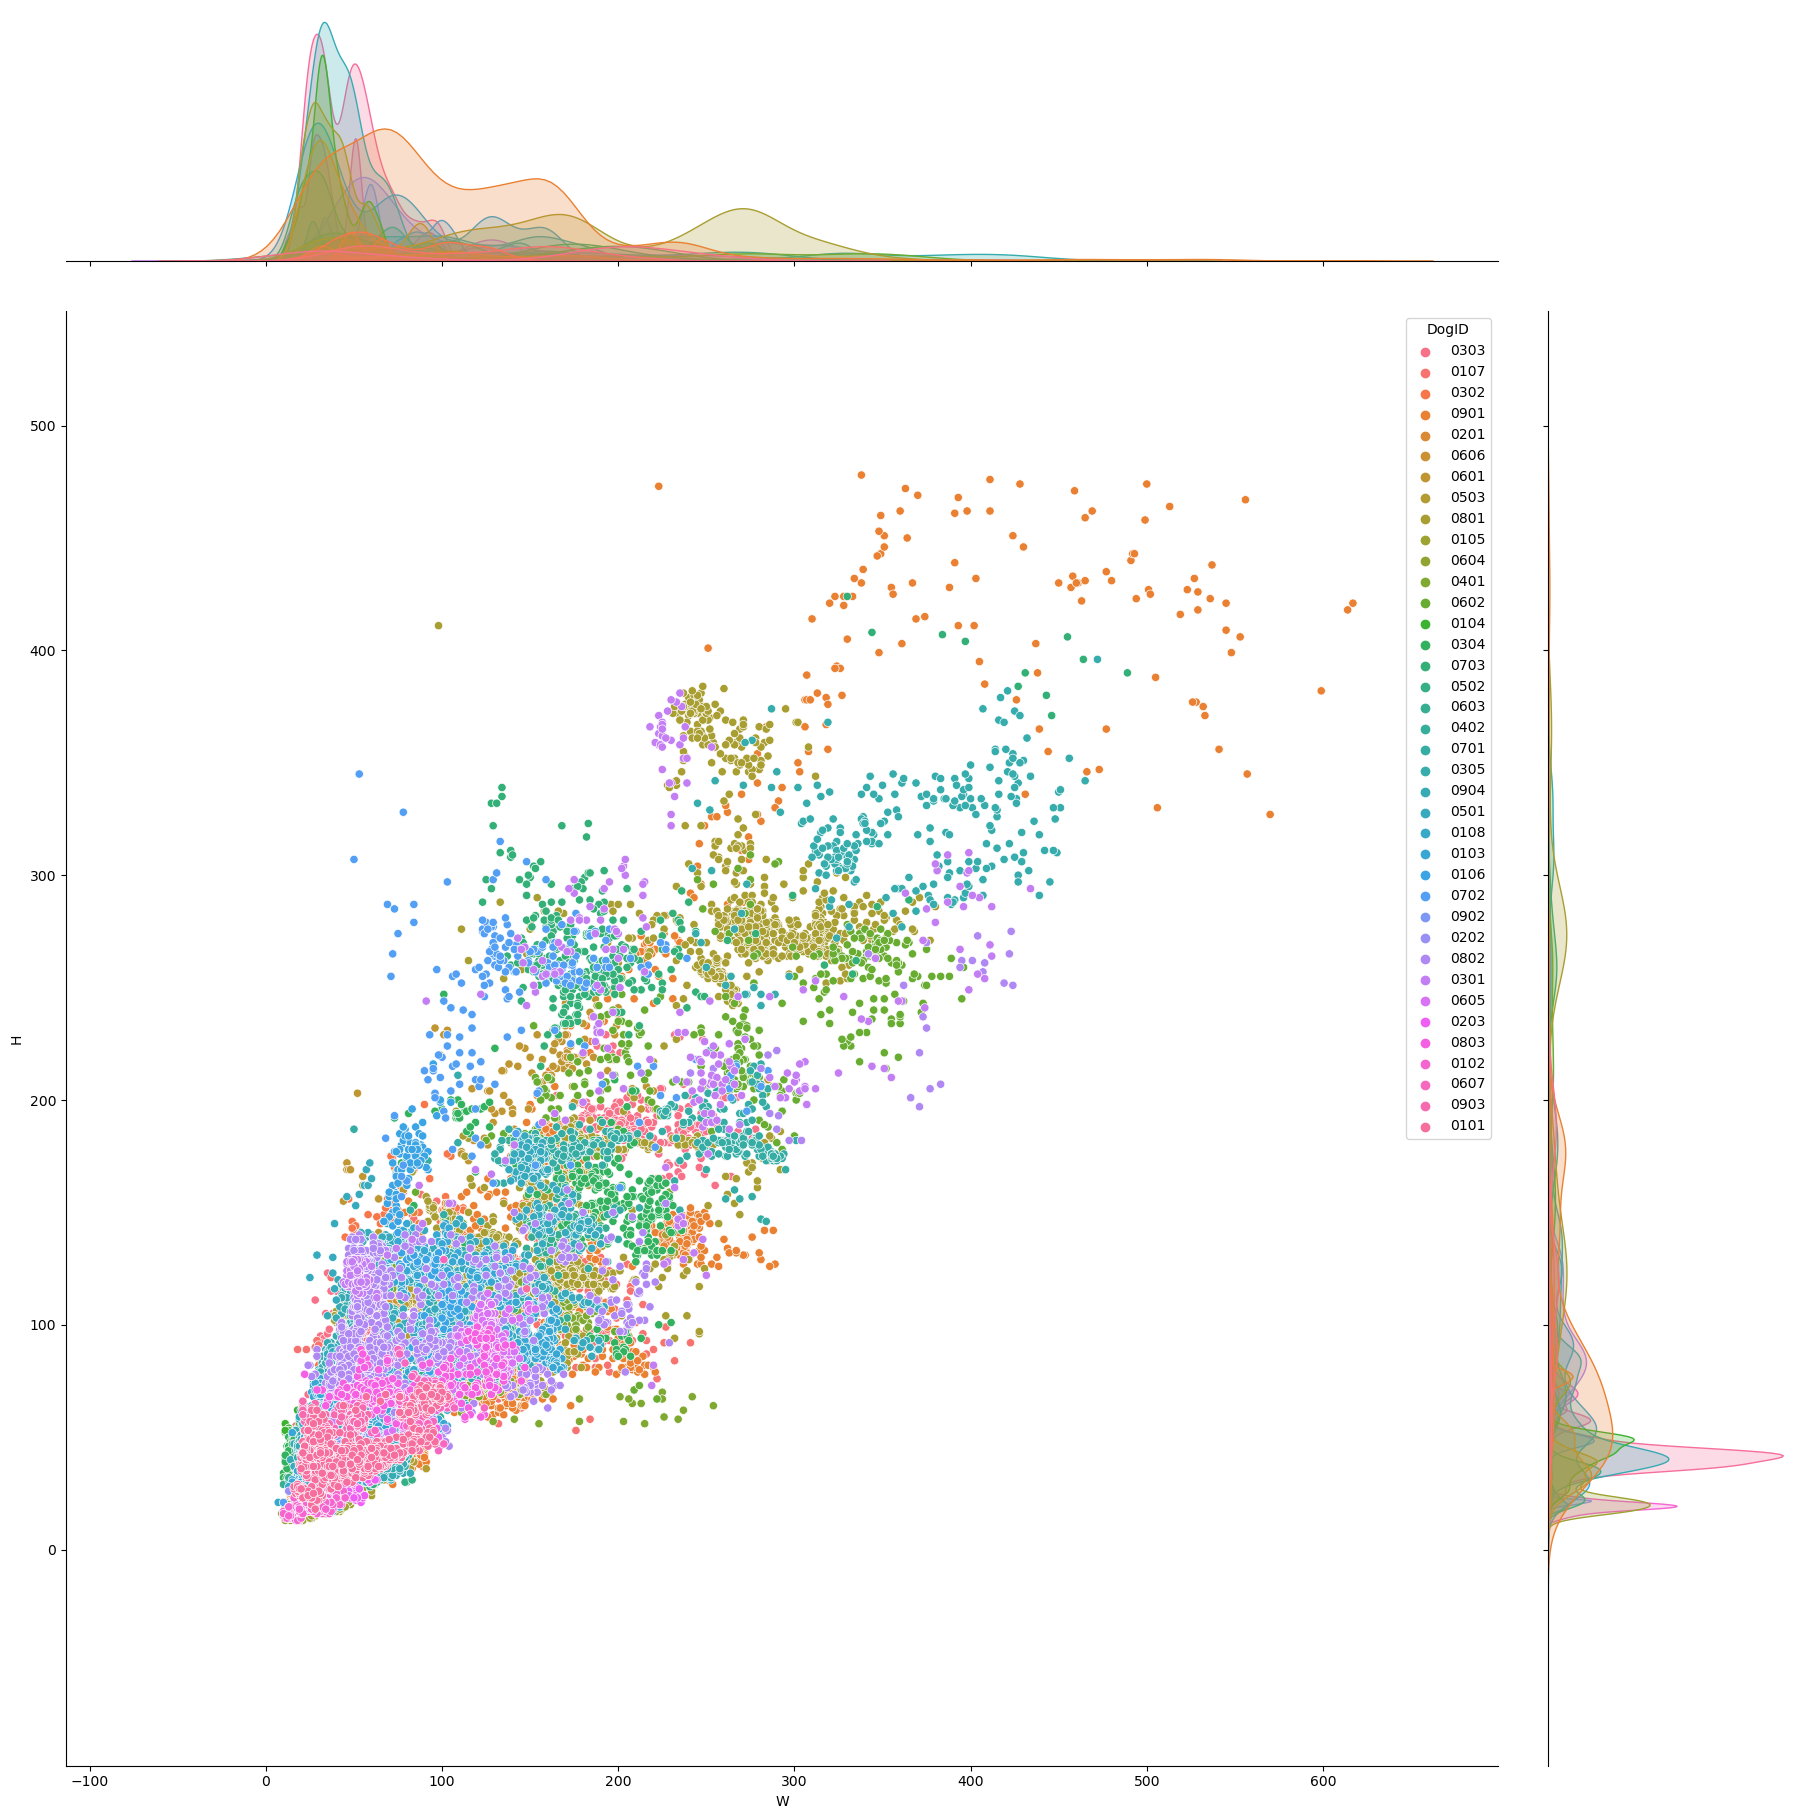

In [9]:
joint_plot = sns.jointplot(data=df, x="W", y="H", kind="scatter", hue='DogID')
joint_plot.fig.set_size_inches(20, 20)
plt.show()

# Data Prepaparation

In [10]:
!rm -r /kaggle/working/dataset

rm: cannot remove '/kaggle/working/dataset': No such file or directory


In [11]:
Tagert_sample = 200

In [12]:
def copy_images_to_folder(df, folder_path):
    for index, row in df.iterrows():
        dog_id = row['DogID']
        src_path = row['filepath']
        dst_dir = os.path.join(folder_path, dog_id)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

In [13]:
#get n numbers of largest images
def get_largest_n_images(df, n=Tagert_sample):
    result_df = pd.DataFrame()
    for dog_id in df['DogID'].unique():
        dog_df = df[df['DogID'] == dog_id]
        largest_images = dog_df.nlargest(n, 'W' if dog_df['W'].max() >= dog_df['H'].max() else 'H')
        result_df = result_df.append(largest_images)
    return result_df

In [14]:
largest_images_df = get_largest_n_images(df, Tagert_sample)

In [15]:
baseDir = '/kaggle/working/dataset'
os.makedirs(baseDir, exist_ok=True)

In [16]:
large_classes = largest_images_df['DogID'].value_counts().index
large_df = largest_images_df[largest_images_df['DogID'].isin(large_classes)]
copy_images_to_folder(large_df, baseDir)

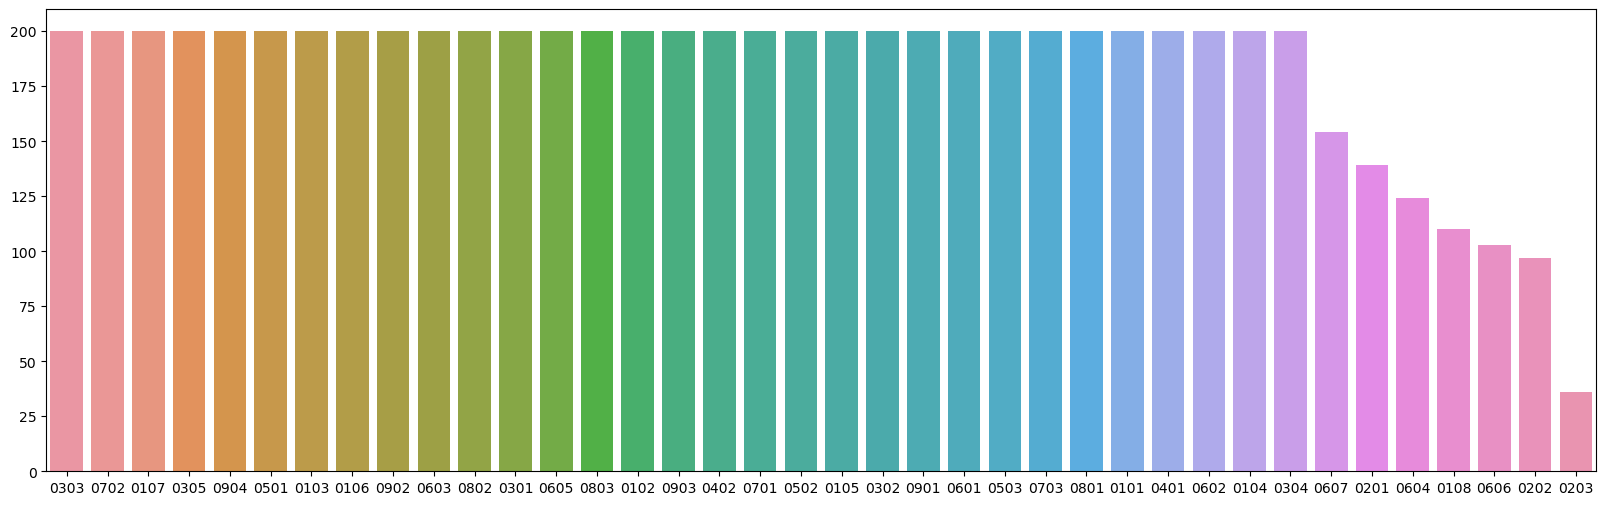

In [17]:
dog_counts = largest_images_df['DogID'].value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(x=dog_counts.index, y=dog_counts.values)
plt.show()

In [18]:
train_df = largest_images_df.copy()
del largest_images_df

In [19]:
train_df

,filepath,W,H,DogID
249,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,278,187,0303
0,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,276,183,0303
45,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,268,186,0303
49,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,268,183,0303
96,/kaggle/input/datasetv2/train/DogID.0303/MVI_0...,267,165,0303
...,...,...,...,...
25836,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,82,50,0101
26220,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,82,48,0101
26577,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,82,47,0101
26645,/kaggle/input/datasetv2/train/DogID.0101/MVI_0...,82,64,0101


# Model

In [20]:
class SiameseNetwork:
    def __init__(self, img_size, margin, base_model_name):
        self.img_size = img_size
        self.margin = margin
        self.base_model_name = base_model_name
        self.embedding_model = self.create_embedding_model()
        self.siamese_model = self.create_siamese_model()  # Create the siamese model here
        self.early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.plot_model = plot_model(self.siamese_model, show_shapes=True, show_layer_names=True)
        
    def create_embedding_model(self):
        if self.base_model_name not in ["VGG16", "MobileNet", "InceptionResNetV2"]:
            raise ValueError("Invalid base model name. Expected 'VGG16', 'MobileNet', or 'InceptionResNetV2'")

        # Special case for InceptionResNetV2
        if self.base_model_name == "InceptionResNetV2":
            base_cnn = applications.inception_resnet_v2.InceptionResNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=(*self.img_size, 3)
            )
        else:
            base_cnn = getattr(applications, self.base_model_name)(
                weights='imagenet',
                include_top=False,
                input_shape=(*self.img_size, 3)
            )

        x = layers.GlobalAveragePooling2D()(base_cnn.output)
        x = layers.Dense(1024, activation='relu')(x)  
        x = layers.BatchNormalization()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        output = layers.Dense(128, activation=None)(x)
        output = layers.Lambda(lambda x: K.l2_normalize(x, axis=-1))(output)  # Add L2 normalization

        return Model(inputs=base_cnn.input, outputs=output)

    def euclidean_distance(self, vects):
        x, y = vects
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))
    
    def triplet_loss(self, y_true, y_pred):
        anchor_positive_distance, anchor_negative_distance = y_pred[:, 0], y_pred[:, 1]
        loss = tf.maximum(anchor_positive_distance - anchor_negative_distance + self.margin, 0.0)
        return tf.reduce_mean(loss)

    def triplet_accuracy(self, y_true, y_pred):
        anchor_positive_distance, anchor_negative_distance = y_pred[:, 0], y_pred[:, 1]
        return tf.reduce_mean(tf.cast(anchor_positive_distance < anchor_negative_distance, tf.float32))

    def create_siamese_model(self):
        anchor_input = layers.Input(shape=(*self.img_size, 3))
        positive_input = layers.Input(shape=(*self.img_size, 3))
        negative_input = layers.Input(shape=(*self.img_size, 3))

        anchor_embedding = self.embedding_model(anchor_input)
        positive_embedding = self.embedding_model(positive_input)
        negative_embedding = self.embedding_model(negative_input)

        positive_distance = layers.Lambda(self.euclidean_distance)([anchor_embedding, positive_embedding])
        negative_distance = layers.Lambda(self.euclidean_distance)([anchor_embedding, negative_embedding])

        stacked_dists = layers.Concatenate()([positive_distance, negative_distance])
        siamese_model = Model([anchor_input, positive_input, negative_input], stacked_dists)
        return siamese_model

    def load_image(self, image_path):
        img = plt.imread(image_path)
        img = np.array(Image.fromarray(img).resize(self.img_size, resample=Image.BILINEAR))
        return img / 255.0
    
    def freeze_unfreeze_layers(self, freeze_until_layer=None):
        # Get the initial count of all weights before any freezing
        initial_weight_count = len(self.embedding_model.weights)
        print(f'Initial total weights: {initial_weight_count}')

        # Freeze all layers initially
        for layer in self.embedding_model.layers:
            layer.trainable = False

        if freeze_until_layer:
            # Find the index of the freeze_until_layer
            freeze_until_index = None
            for i, layer in enumerate(self.embedding_model.layers):
                if layer.name == freeze_until_layer:
                    freeze_until_index = i
                    break
            # If the layer is found in the model, unfreeze layers from that point onwards
            if freeze_until_index is not None:
                for layer in self.embedding_model.layers[freeze_until_index:]:
                    layer.trainable = True
            else:
                print(f'Could not find layer {freeze_until_layer} in the model. All layers are kept frozen.')

        # Get the count of trainable weights after freezing and unfreezing
        trainable_weight_count = len(self.embedding_model.trainable_weights)
        print(f'Trainable weights after freezing/unfreezing: {trainable_weight_count}')

    def data_generator(self, data_df, batch_size):
        while True:
            data_df = data_df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
            for i in range(0, len(data_df), batch_size):
                batch_df = data_df[i:i + batch_size]
                anchor_batch, positive_batch, negative_batch = [], [], []
                for _, row in batch_df.iterrows():
                    anchor_img_path = row['filepath']
                    anchor_dog_id = row['DogID']

                    # Get positive image
                    positive_df = data_df[data_df['DogID'] == anchor_dog_id]
                    if positive_df.shape[0] < 2:  # Not enough positive images
                        continue
                    positive_row = positive_df.sample(n=1).iloc[0]
                    while positive_row['filepath'] == anchor_img_path:
                        positive_row = positive_df.sample(n=1).iloc[0]

                    # Get negative image
                    negative_df = data_df[data_df['DogID'] != anchor_dog_id]
                    if negative_df.empty:  # No negative images
                        continue
                    negative_img_path = negative_df.sample(n=1).iloc[0]['filepath']

                    anchor_batch.append(self.load_image(anchor_img_path))
                    positive_batch.append(self.load_image(positive_row['filepath']))
                    negative_batch.append(self.load_image(negative_img_path))

                if len(anchor_batch) == 0:  # No valid images in this batch
                    continue

                anchor_batch = np.array(anchor_batch)
                positive_batch = np.array(positive_batch)
                negative_batch = np.array(negative_batch)
                dummy_labels = np.zeros((len(anchor_batch), 1))  # Add dummy labels
                yield [anchor_batch, positive_batch, negative_batch], dummy_labels
                gc.collect()
                
    def visualize(self, data_df, batch_size):
        """Visualize a few triplets from the supplied batches."""

        def show(ax, image, label):
            ax.imshow(image)
            ax.set_title(label)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        # Get a batch of data from the data generator
        input_data, _ = next(self.data_generator(data_df, batch_size))
        anchor_batch, positive_batch, negative_batch = input_data

        fig, axs = plt.subplots(batch_size, 3, figsize=(9, 3*batch_size))

        for i in range(batch_size):
            show(axs[i, 0], anchor_batch[i], "Batch {} Anchor".format(i+1))
            show(axs[i, 1], positive_batch[i], "Batch {} Positive".format(i+1))
            show(axs[i, 2], negative_batch[i], "Batch {} Negative".format(i+1))

        plt.tight_layout()
        plt.show()

            
    def train(self, data_df, epochs, batch_size, n_folds=5, **kwargs):
        kfold = KFold(n_splits=n_folds, shuffle=True)
        results = []
        histories = []  # Store histories here

        # KFold cross-validation
        for train_indices, val_indices in kfold.split(data_df):
            train_df = data_df.iloc[train_indices]
            val_df = data_df.iloc[val_indices]

            self.freeze_unfreeze_layers(**kwargs)
            self.siamese_model.compile(optimizer=Adam(1e-4), loss=self.triplet_loss, metrics=[self.triplet_accuracy])
            train_gen = self.data_generator(train_df, batch_size)
            val_gen = self.data_generator(val_df, batch_size)

            history = self.siamese_model.fit(train_gen, steps_per_epoch=len(train_df)//batch_size, 
                                   validation_data=val_gen, validation_steps=len(val_df)//batch_size,
                                   epochs=epochs, callbacks=[self.early_stopping])
            histories.append(history)  # Append the current fold's history

            # Evaluate model performance on validation set
            val_accuracy = self.siamese_model.evaluate(val_gen, steps=len(val_df)//batch_size)[1]
            results.append(val_accuracy)

        average_accuracy = sum(results) / n_folds
        print(f'Average accuracy: {average_accuracy}')
        return histories  

        
    def save(self, filepath): 
        self.embedding_model.save(filepath + '/model.h5')
        self.embedding_model.save_weights(filepath + '/weight.h5')

In [21]:
model = SiameseNetwork(img_size = (224,224), margin = 0.3, base_model_name="InceptionResNetV2") #["VGG16", "MobileNet", "InceptionResNetV2"]

219055592/219055592 [==============================] - 1s 0us/step


![kfold](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

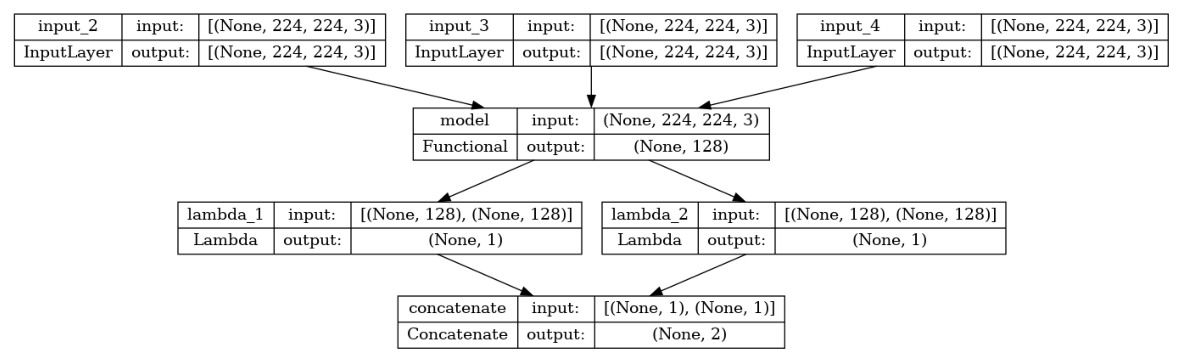

In [22]:
plot_model = plt.imread('/kaggle/working/model.png')
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(plot_model)
plt.axis('off')
plt.show()


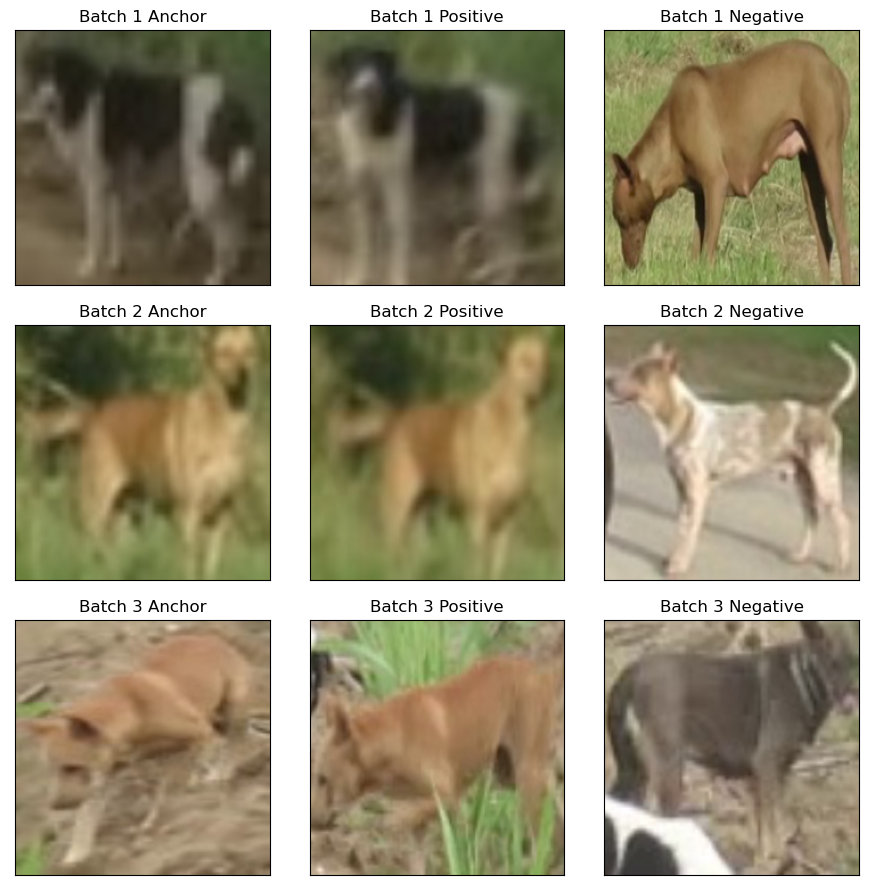

In [23]:
model.visualize(train_df, batch_size=3)

In [24]:
import time
time_start = time.time()
history = model.train(train_df, epochs = 5, batch_size = 32, n_folds = 3, freeze_until_layer='block8_1_conv')#(inceptionresnetv2:block8_1_conv)(vgg16:block5_conv1)
print('Done training! Time elapsed: {} seconds'.format(time.time() - time_start))

Initial total weights: 916
Trainable weights after freezing/unfreezing: 108
Epoch 1/5
145/145 [==============================] - 280s 2s/step - loss: 0.0265 - triplet_accuracy: 0.9750 - val_loss: 0.0063 - val_triplet_accuracy: 0.9952
Epoch 2/5
145/145 [==============================] - 204s 1s/step - loss: 0.0065 - triplet_accuracy: 0.9944 - val_loss: 0.0041 - val_triplet_accuracy: 0.9957
Epoch 3/5
145/145 [==============================] - 204s 1s/step - loss: 0.0025 - triplet_accuracy: 0.9987 - val_loss: 0.0030 - val_triplet_accuracy: 0.9957
Epoch 4/5
145/145 [==============================] - 203s 1s/step - loss: 0.0020 - triplet_accuracy: 0.9989 - val_loss: 0.0022 - val_triplet_accuracy: 0.9978
Epoch 5/5
72/72 [==============================] - 72s 1s/step - loss: 0.0018 - triplet_accuracy: 0.9983
Initial total weights: 916
Trainable weights after freezing/unfreezing: 108
Epoch 1/5
145/145 [==============================] - 317s 2s/step - loss: 0.0033 - triplet_accuracy: 0.9972 - v

In [25]:
model.save('output')

In [26]:
history[0].history,history[1].history,history[2].history

({'loss': [0.026465661823749542,
   0.006502832286059856,
   0.002463462995365262,
   0.002010683761909604,
   0.0014339744811877608],
  'triplet_accuracy': [0.9750000238418579,
   0.9943965673446655,
   0.9987068772315979,
   0.9989224076271057,
   0.9993534684181213],
  'val_loss': [0.00633234204724431,
   0.004061834421008825,
   0.0030225063674151897,
   0.002223235322162509,
   0.002025355352088809],
  'val_triplet_accuracy': [0.9952256679534912,
   0.9956597089767456,
   0.9956597089767456,
   0.9978298544883728,
   0.9978298544883728]},
 {'loss': [0.003283086232841015,
   0.001905508921481669,
   0.0015253049787133932,
   0.000988844083622098,
   0.0018066705670207739],
  'triplet_accuracy': [0.9971982836723328,
   0.9987068772315979,
   0.9989224076271057,
   0.9995689392089844,
   0.998275876045227],
  'val_loss': [0.0008443976403214037,
   0.0008503303397446871,
   0.0008602573652751744,
   0.0019178177462890744,
   0.0017564711160957813],
  'val_triplet_accuracy': [1.0,
   0

In [27]:
def evaluation(histories):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    for i, history in enumerate(histories):
        history_dict = history.history  # Get the history dictionary
        epochs = range(1, len(history_dict['loss']) + 1)
        
        ax[0].plot(epochs, history_dict['loss'], 'o-', label='Training loss - Fold {}'.format(i+1))
        ax[0].plot(epochs, history_dict['val_loss'], 'o-', label='Validation loss - Fold {}'.format(i+1))
        ax[0].set_title('Training and Validation Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()
        
        ax[1].plot(epochs, history_dict['triplet_accuracy'], 'o-', label='Training accuracy - Fold {}'.format(i+1))
        ax[1].plot(epochs, history_dict['val_triplet_accuracy'], 'o-', label='Validation accuracy - Fold {}'.format(i+1))
        ax[1].set_title('Training and Validation Accuracy')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        
    plt.tight_layout()
    plt.show()


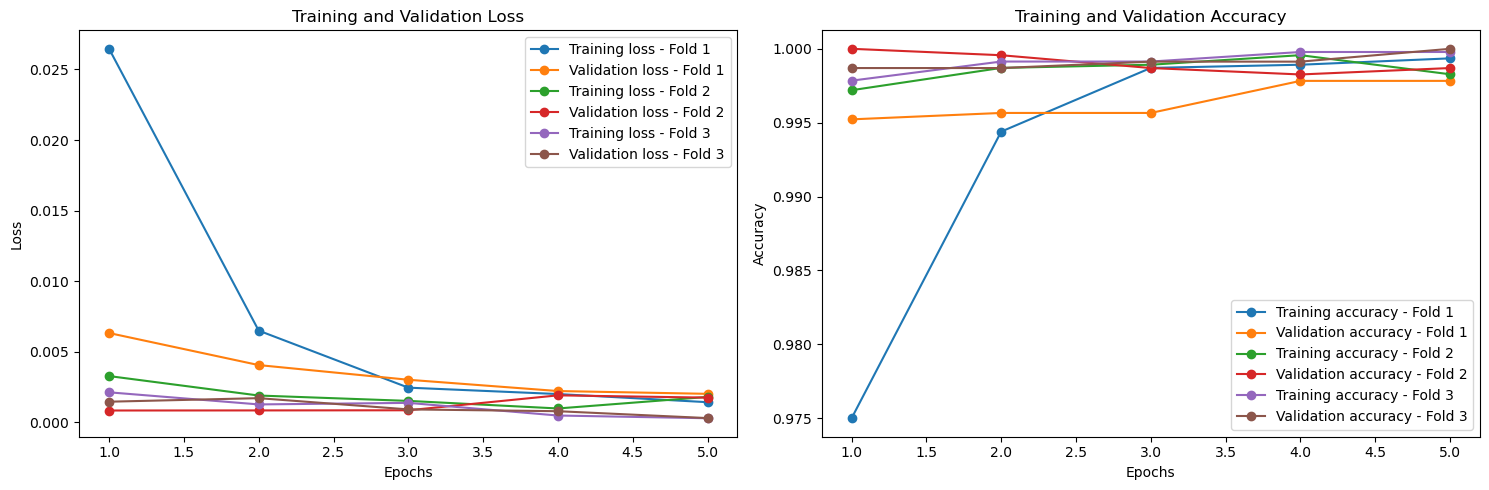

In [28]:
evaluation(history)